In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker in ('F', 'GE', 'GM', 'XOM')
    limit 100
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

symbol     market_datetime   open
0      F 2005-01-03 06:00:00  14.66
1     GM 2005-01-03 06:00:00  40.65
2     GE 2005-01-03 06:00:00  36.71
3    XOM 2005-01-03 06:00:00  51.02
4      F 2005-01-04 06:00:00  14.71

### Clean data

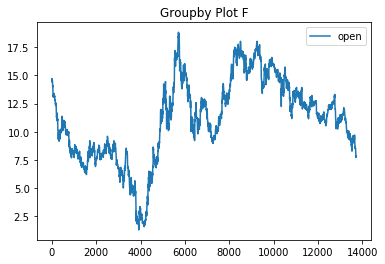

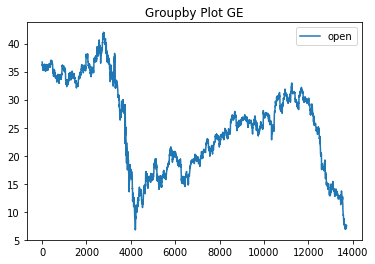

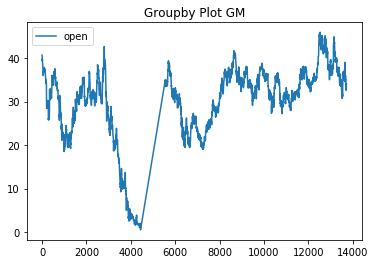

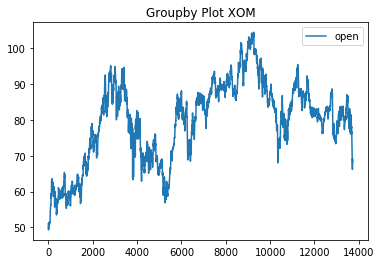

In [3]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

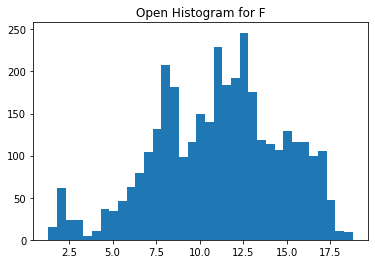

In [4]:
plt.hist(df.loc[df['symbol']==df['symbol'].values[0], 'open'], bins=35)
plt.title('Open Histogram for ' + df['symbol'].values[0])
plt.show()

### Lstm on open data

In [5]:
df['target'] = df['open']

column = 'open'
subset = 'symbol'
window_size = 100

df['open_min'], df['open_max'] = 0, 0
for val in df[subset].unique():
    df.loc[df[subset] == val, 'open_min'] = df.loc[df[subset] == val, column].rolling(window_size).min()
    df.loc[df[subset] == val, 'open_max'] = df.loc[df[subset] == val, column].rolling(window_size).max()
    df.loc[df[subset] == val, column] = ((df.loc[df[subset] == val, column] - df.loc[df[subset] == val, 'open_min']) 
                                         / (df.loc[df[subset] == val, 'open_max'] - df.loc[df[subset] == val, 'open_min']))

df = df[df['open'].notnull()]

In [6]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

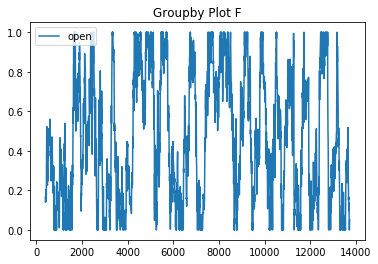

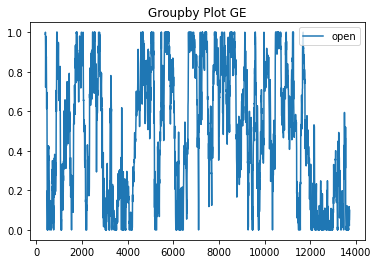

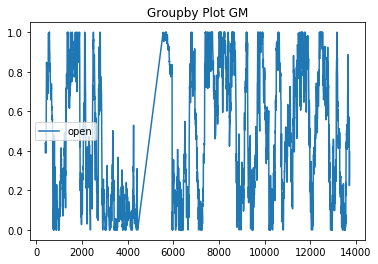

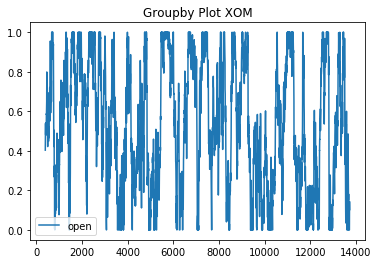

In [7]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

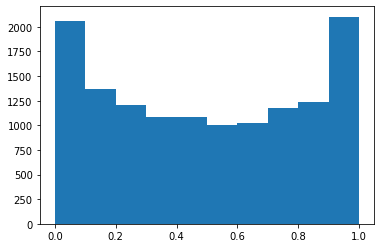

In [8]:
plt.hist(df['open'])
plt.show()

In [9]:
dfs = []
sequence_length=100

for symbol, data in df.groupby('symbol'):
    for offset in range(1, sequence_length, 1):
        data = data.join(data['open'].shift(offset), rsuffix='_' + str(abs(offset)))
    dfs.append(data)

train_test = pd.concat(dfs)
train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')
print(train_test.shape)
train_test.head(10)

(12932, 109)


symbol     market_datetime      open  target  open_min  open_max  \
793      F 2005-10-14 05:00:00  0.036765    8.75      8.65     11.37   
792     GM 2005-10-14 05:00:00  0.122570   27.15     25.70     37.53   
795    XOM 2005-10-14 05:00:00  0.267317   57.80     55.06     65.31   
794     GE 2005-10-14 05:00:00  0.364078   34.40     32.90     37.02   
796      F 2005-10-17 05:00:00  0.220588    9.25      8.65     11.37   
798     GM 2005-10-17 05:00:00  0.480981   31.39     25.70     37.53   
799     GE 2005-10-17 05:00:00  0.317961   34.21     32.90     37.02   
797    XOM 2005-10-17 05:00:00  0.323974   59.05     56.05     65.31   
800     GM 2005-10-18 05:00:00  0.344041   29.77     25.70     37.53   
802      F 2005-10-18 05:00:00  0.000000    8.61      8.61     11.37   

     symbol_F  symbol_GE  symbol_GM  symbol_XOM  ...   open_90   open_91  \
793         1          0          0           0  ...  0.199187  0.154440   
792         0          0          1           0  ...  0.484647  0.405705   
795         0          0          0           1  ...  0.522273  0.542243   
794         0          1          0           0  ...  0.979381  0.871134   
796         1          0          0           0  ...  0.189024  0.199187   
798         0          0          1           0  ...  0.516183  0.484647   
799         0          1          0           0  ...  0.860825  0.979381   
797         0          0          0           1  ...  0.491106  0.522273   
800         0          0          1           0  ...  0.523651  0.516183   
802         1          0          0           0  ...  0.176829  0.189024   

      open_92   open_93   open_94   open_95   open_96   open_97   open_98  \
793  0.142315  0.202226  0.155844  0.163265  0.168831  0.170018  0.160360   
792  0.389151  0.418423  0.417234  0.429806  0.435565  0.440400  0.411765   
795  0.535846  0.536000  0.517818  0.481455  0.539216  0.497199  0.472689   
794  0.809278  0.886598  0.907216  0.721649  0.927835  0.948454  1.000000   
796  0.154440  0.142315  0.202226  0.155844  0.163265  0.168831  0.170018   
798  0.405705  0.389151  0.418423  0.417234  0.429806  0.435565  0.440400   
799  0.871134  0.809278  0.886598  0.907216  0.721649  0.927835  0.948454   
797  0.542243  0.535846  0.536000  0.517818  0.481455  0.539216  0.497199   
800  0.484647  0.405705  0.389151  0.418423  0.417234  0.429806  0.435565   
802  0.199187  0.154440  0.142315  0.202226  0.155844  0.163265  0.168831   

      open_99  
793  0.142342  
792  0.391392  
795  0.403361  
794  0.989691  
796  0.160360  
798  0.411765  
799  1.000000  
797  0.472689  
800  0.440400  
802  0.170018  

[10 rows x 109 columns]

In [10]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'target']

data_size = 3000
model = nn_utils.TorchLSTM(train_x=train_test.drop(cols_to_ignore, axis=1).head(data_size), 
                           train_y=train_test['open'].head(data_size), 
                           test_x=train_test.drop(cols_to_ignore, axis=1).head(data_size), 
                           test_y=train_test['open'].tail(data_size),
                           n_layers=2,
                           n_epochs=1000,
                           hidden_shape=1000,
                           batch_size=10,
                           dropout=.3,
                           learning_rate=.0001,
                           device='cuda:1')

Epoch  0 Error:  1375.5064697265625
Epoch  100 Error:  366.823974609375
Epoch  200 Error:  259.8668212890625
Epoch  300 Error:  217.04893493652344
Epoch  400 Error:  203.90960693359375
Epoch  500 Error:  183.01705932617188
Epoch  600 Error:  181.26565551757812
Epoch  700 Error:  171.83946228027344
Epoch  800 Error:  164.71319580078125
Epoch  900 Error:  150.86061096191406


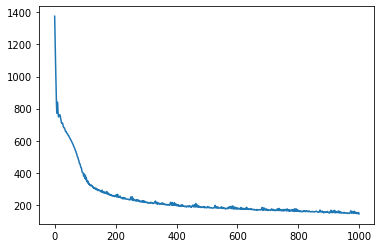

In [11]:
model.execute()

In [12]:
model.reset_network()

In [13]:
test_df = model.test_df
temp = train_test[cols_to_ignore].tail(data_size).reset_index(drop=True)
test_df = test_df.join(temp)
test_df.head()

symbol_F  symbol_GE  symbol_GM  symbol_XOM    open_1    open_2    open_3  \
0       1.0        0.0        0.0         0.0  0.000000  0.000000  0.000000   
1       0.0        0.0        1.0         0.0  0.065089  0.108199  0.000000   
2       0.0        0.0        0.0         1.0  0.348948  0.457457  0.421775   
3       0.0        1.0        0.0         0.0  0.206311  0.165049  0.264563   
4       1.0        0.0        0.0         0.0  0.036765  0.000000  0.000000   

     open_4    open_5    open_6  ...   open_98   open_99   actuals  \
0  0.000000  0.000000  0.030612  ...  0.160360  0.142342  0.232092   
1  0.000000  0.000000  0.000000  ...  0.411765  0.391392  0.753555   
2  0.504770  0.459670  0.440305  ...  0.472689  0.403361  0.445154   
3  0.322816  0.242718  0.067961  ...  1.000000  0.989691  0.339785   
4  0.000000  0.000000  0.000000  ...  0.170018  0.160360  0.330108   

   prediction  symbol     market_datetime      open  open_min  open_max  \
0    0.000371       F 2016-01-08 06:00:00  0.232092     12.24     15.73   
1    0.093538      GE 2016-01-08 06:00:00  0.753555     22.84     31.28   
2    0.311909     XOM 2016-01-08 06:00:00  0.445154     67.99     86.77   
3    0.185365      GM 2016-01-08 06:00:00  0.339785     27.30     36.60   
4   -0.001764      GM 2016-01-11 06:00:00  0.330108     27.30     36.60   

   target  
0   13.05  
1   29.20  
2   76.35  
3   30.46  
4   30.37  

[5 rows x 111 columns]

In [14]:
test_df['prediction_mapped'] = (test_df['prediction'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['actuals_mapped'] = (test_df['actuals'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['errors'] = test_df['prediction'] - test_df['actuals']

In [15]:
test_df.head(10)

symbol_F  symbol_GE  symbol_GM  symbol_XOM    open_1    open_2    open_3  \
0       1.0        0.0        0.0         0.0  0.000000  0.000000  0.000000   
1       0.0        0.0        1.0         0.0  0.065089  0.108199  0.000000   
2       0.0        0.0        0.0         1.0  0.348948  0.457457  0.421775   
3       0.0        1.0        0.0         0.0  0.206311  0.165049  0.264563   
4       1.0        0.0        0.0         0.0  0.036765  0.000000  0.000000   
5       0.0        0.0        1.0         0.0  0.122570  0.065089  0.108199   
6       0.0        1.0        0.0         0.0  0.364078  0.206311  0.165049   
7       0.0        0.0        0.0         1.0  0.267317  0.348948  0.457457   
8       0.0        0.0        1.0         0.0  0.480981  0.122570  0.065089   
9       1.0        0.0        0.0         0.0  0.220588  0.036765  0.000000   

     open_4    open_5    open_6  ...  prediction  symbol     market_datetime  \
0  0.000000  0.000000  0.030612  ...    0.000371       F 2016-01-08 06:00:00   
1  0.000000  0.000000  0.000000  ...    0.093538      GE 2016-01-08 06:00:00   
2  0.504770  0.459670  0.440305  ...    0.311909     XOM 2016-01-08 06:00:00   
3  0.322816  0.242718  0.067961  ...    0.185365      GM 2016-01-08 06:00:00   
4  0.000000  0.000000  0.000000  ...   -0.001764      GM 2016-01-11 06:00:00   
5  0.000000  0.000000  0.000000  ...    0.127526      GE 2016-01-11 06:00:00   
6  0.264563  0.322816  0.242718  ...    0.250290       F 2016-01-11 06:00:00   
7  0.421775  0.504770  0.459670  ...    0.266100     XOM 2016-01-11 06:00:00   
8  0.108199  0.000000  0.000000  ...    0.394618      GE 2016-01-12 06:00:00   
9  0.000000  0.000000  0.000000  ...    0.146039      GM 2016-01-12 06:00:00   

       open  open_min  open_max  target  prediction_mapped  actuals_mapped  \
0  0.232092     12.24     15.73   13.05          12.241296           13.05   
1  0.753555     22.84     31.28   29.20          23.629460           29.20   
2  0.445154     67.99     86.77   76.35          73.847647           76.35   
3  0.339785     27.30     36.60   30.46          29.023892           30.46   
4  0.330108     27.30     36.60   30.37          27.283594           30.37   
5  0.675355     22.84     31.28   28.54          23.916318           28.54   
6  0.160458     12.24     15.73   12.80          13.113513           12.80   
7  0.373802     67.99     86.77   75.01          72.987366           75.01   
8  0.701422     22.84     31.28   28.76          26.170574           28.76   
9  0.358065     27.30     36.60   30.63          28.658159           30.63   

     errors  
0 -0.231720  
1 -0.660017  
2 -0.133246  
3 -0.154420  
4 -0.331872  
5 -0.547830  
6  0.089832  
7 -0.107702  
8 -0.306804  
9 -0.212026  

[10 rows x 114 columns]

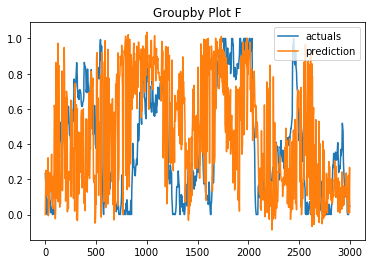

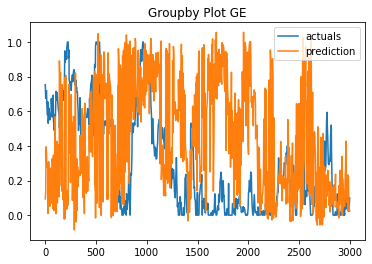

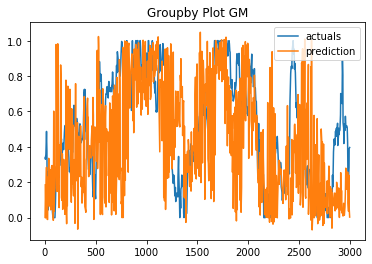

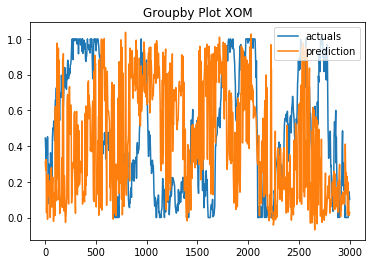

In [16]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['actuals', 'prediction'])

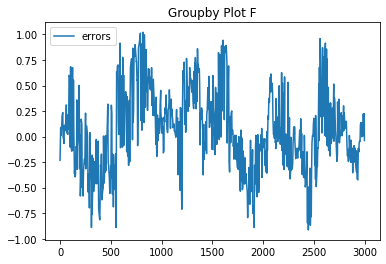

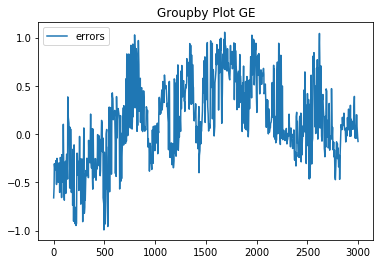

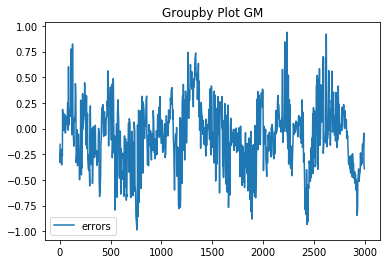

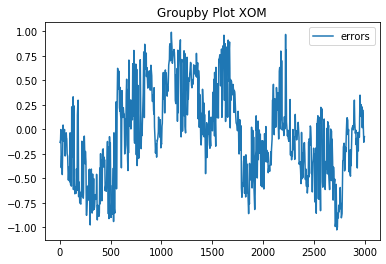

In [17]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['errors'])

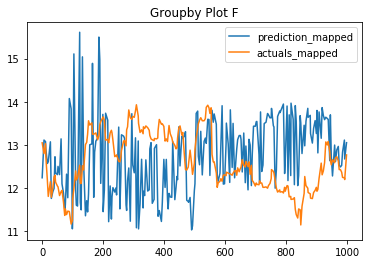

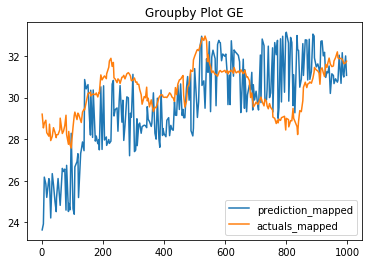

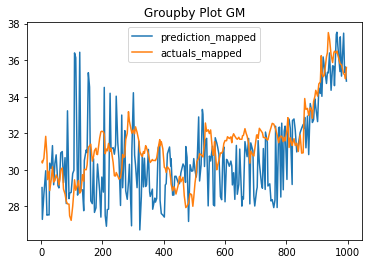

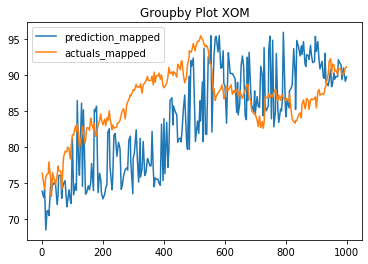

In [18]:
cluster_utils.plot_groupby(test_df.head(1000), 'symbol', lines=['prediction_mapped', 'actuals_mapped'])

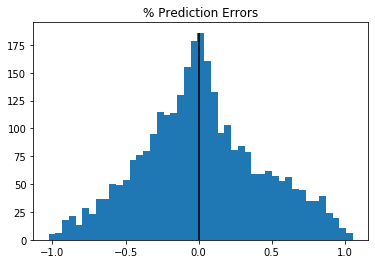

In [19]:
plt.title('% Prediction Errors')
plot = plt.hist(test_df['errors'], bins=45)
plt.vlines(0, ymin=0, ymax=plot[0].max())
plt.show()